# Linear program test with OR Tools

Google's OR python package

**Import python libraries**

Ortools was not loaded through Anaconda, it was installed with Pip, so it does not show up in the list of packages in the optimization environment but it is available.  See installation requirments in documentation, in particular Windows computers need the MS C++ redistributable installed, https://developers.google.com/optimization/install/python/windows.

In [1]:
#!pip install ortools==7.8.7959 --force-reinstall

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import time
import ortools
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
import seaborn as sns

**See Google example**

This link has the code for the "Hello World" example from Google's reference pages.

https://developers.google.com/optimization/introduction/python

## Setting up the optimization inputs
**Read in data for hourly profiles and set cost inputs**

In [3]:
# start timer
total_time_0 = time.time()

# set up some variables
# these will be inputs from the user

# boolean for debug printing
debug_print = False


# flag for using outside energy to meet load obligations
use_outside_energy = False
outside_energy_cost = 10000

peak_load = 1000

diverse_profile = True

# restrict gas to a portion of total load, 0-1 or None
# e.g. 5 -> 5% limit on gas generation 
# and  100 -> no limit on gas generation
restrict_gas = 100

# divide by 100 since input is in percentages
restrict_gas = restrict_gas/100


# battery parameters
min_charge_level = 0.1
init_ch_level = 0.5
batt_hours = 4
batt_eff = 0.85


# amount of CO2 per MW and MWh
# CO2 values from CSU study
gas_co2_ton_per_mwh = (411 + 854)/2000
# assumed 30 year life
gas_co2_ton_per_mw = (5981+1000+35566+8210+10165+1425)/(6*18)/30

wind_co2_ton_per_mwh = 0.2/2000
# assumed 30 year life
wind_co2_ton_per_mw = (754+10-241)/30

solar_co2_ton_per_mwh = 2.1/2000
# assumed 30 year life
solar_co2_ton_per_mw = (1202+250-46)/30

# battery C02 given in lbs
# assumed 15 year life
batt_co2_ton_per_mw = (1940400-83481+4903)/2000/15


# cost of C02 in $/ton
#co2_cost = 60
co2_cost = 1000

In [4]:
# calculate costs in $/MWh and $/MW 
# these costs include the cost of carbon

cc_gas_mwh = co2_cost * gas_co2_ton_per_mwh
cc_gas_mw = co2_cost * gas_co2_ton_per_mw

cc_wind_mwh = co2_cost * wind_co2_ton_per_mwh
cc_wind_mw = co2_cost * wind_co2_ton_per_mw

cc_solar_mwh = co2_cost * solar_co2_ton_per_mwh
cc_solar_mw = co2_cost * solar_co2_ton_per_mw

cc_batt_mw = co2_cost * batt_co2_ton_per_mw


# get fixed and variable costs
# include cost of carbon into these numbers

# capacity cost in $/kw-mo
gas_cap_cost = 10.94 # CAPEX + FOM + Firm gas in $/kw-mo
gas_mw_cost = cc_gas_mw + gas_cap_cost*12*1000 # converted to $/MW-yr

heat_rate = 8403 # btu/kwh
vom = 6.73 # $/mwh
gas_fuel_cost = 4.37 # fuel cost in $/mmbtu
gas_trans_cost = 1.06 # transportation cost in $/mmbtu
gas_mwh_cost = cc_gas_mwh + (gas_fuel_cost+gas_trans_cost)*heat_rate/1000 + vom

batt_cost = 8.25
batt_mw_cost = cc_batt_mw + batt_cost*12*1000  # converted to $/MW-yr

wind_kw_mo = 4.85 # includes PSCo schedule 3VER 
wind_mw_cost = cc_wind_mw + wind_kw_mo*12*1000  # converted to $/MW-yr
wind_mwh_cost = cc_wind_mwh + 26.25 # $/mwh


solar_kw_mo = 0.19 # PSCo schedule 3VER
solar_mw_cost = cc_solar_mw + solar_kw_mo*12*1000  # converted to $/MW-yr
solar_mwh_cost = cc_solar_mwh + 33.68 # $/mwh

In [5]:
# read profile data for load and re gen
if diverse_profile:
    profile_data = 'lp_test_profiles_8760_2018_re_diverse.csv'
else:
    profile_data = 'lp_test_profiles_8760_2018_re.csv'

# read profiles
df = pd.read_csv(profile_data, index_col = 'Hour')

# scale load to peak_load input
df['2030_load'] = df['2030_load'] * peak_load

print('Load and generation data:')
display(df.head())
print('\n')

print('Summary of load and generation data:')
display(df.describe())
print('\n')

Load and generation data:


,Months,d,Date,2030_load,solar,wind
Hour,,,,,,
0,1,0,1/1/2018,540.259123,0.0,0.231894
1,1,0,1/1/2018,525.379905,0.0,0.214868
2,1,0,1/1/2018,515.983095,0.0,0.233933
3,1,0,1/1/2018,511.909875,0.0,0.254436
4,1,0,1/1/2018,515.779413,0.0,0.275540




Summary of load and generation data:


,Months,d,2030_load,solar,wind
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,6.526027,182.000000,529.590356,0.239846,0.409203
std,3.448048,105.372043,97.530653,0.303447,0.273125
min,1.000000,0.000000,371.929858,0.000000,0.000000
25%,4.000000,91.000000,461.484798,0.000000,0.178147
50%,7.000000,182.000000,512.214951,0.001711,0.372482
75%,10.000000,273.000000,574.763749,0.505101,0.610462
max,12.000000,364.000000,1000.000000,0.987072,1.000000


**Instantiate a linear model using Google's GLOP solver**

In [6]:
# Create the linear solver with the GLOP backend.
solver = pywraplp.Solver('simple_lp_program', pywraplp.Solver.GLOP_LINEAR_PROGRAMMING)
#solver = pywraplp.Solver('simple_lp_program', pywraplp.Solver.CLP_LINEAR_PROGRAMMING)
#solver.SetNumThreads(num_theads = 8)

**Instantiate build capacity decision variables**

In [7]:
# build capacity decision variables for the resources

batt = solver.NumVar(0, solver.infinity(), 'batt')
solar = solver.NumVar(0, solver.infinity(), 'solar')
wind = solver.NumVar(0, solver.infinity(), 'wind')
gas = solver.NumVar(0, solver.infinity(), 'gas')

#solver.Add(batt + solar + wind + gas >= df['2030_load'].max())

# use this to fix the amount of solar and wind and solve for battery MW
#solver.Add(solar <= 900)
#solver.Add(solar >= 900)
#solver.Add(wind <= 850)
#solver.Add(wind >= 850)

print('Number of variables =', solver.NumVariables())

Number of variables = 4


**Instantiate hourly generation and storage variables and hourly constraints**

First allocate arrays to hold the hourly variables and then instaite them in a loop.  Constraints are also added in the loop.  Note that the hourly profiles for wind and solar are fixed so we just multply those profiles by the build capacity to get the hourly generation values, reducing the number of decision variables in the model.

https://stackoverflow.com/questions/56693918/how-to-declare-dynamic-variables-inside-for-loop-in-or-tools

I had tried to implement this solution:

https://math.stackexchange.com/questions/2056828/linear-programming-how-to-formulate-a-condition-that-product-of-two-variables-m

to ensure that only batt_ch or batt_disch is positive for any hour but I cannont multiply an interger variable with a numeric variable.  I added a $0.01 cost to energy moving in or out of the battery and that has solved this issue.

In [8]:
# generation decision variables
t0 = time.time()

# create arrays to hold hourly varaibles
# we don't need solar and wind since the profiles are fixed
batt_ch         = [None] * len(df.index)
batt_disch      = [None] * len(df.index)
gas_gen         = [None] * len(df.index)
SOC             = [None] * len(df.index)
if use_outside_energy: outside_energy  = [None] * len(df.index)


t_h = time.time() # for tracking time in hourly loop
for h in df.index:

    if h % 100 == 0 and debug_print:
            print("h: ", h, "\tET: ", round(time.time()-t_h, 2))
            t_h = time.time()

    # add hourly variables
    batt_ch[h] = solver.NumVar(0, solver.infinity(), 'batt_ch[{}]'.format(h))
    batt_disch[h] = solver.NumVar(0, solver.infinity(), 'batt_disch[{}]'.format(h))
    gas_gen[h] = solver.NumVar(0, solver.infinity(), 'gas_gen[{}]'.format(h))
    SOC[h] = solver.NumVar(0, solver.infinity(), 'SOC[{}]'.format(h))
    if use_outside_energy: outside_energy[h] = solver.NumVar(0, solver.infinity(), 'outside_energy[{}]'.format(h))


    # add hourly constraints

    # set SOC[h] equal to previous hour SOC 
    # plus the change from charging or discharging
    if h == 0:
        solver.Add(SOC[h] <= init_ch_level*4*batt + batt_ch[h] - batt_disch[h]/batt_eff)
        solver.Add(SOC[h] >= init_ch_level*4*batt + batt_ch[h] - batt_disch[h]/batt_eff)
    else:
        solver.Add(SOC[h] <= SOC[h-1] + batt_ch[h] - batt_disch[h]/batt_eff)
        solver.Add(SOC[h] >= SOC[h-1] + batt_ch[h] - batt_disch[h]/batt_eff)



    # SOC mwh constraints
    # max mwh constraint
    solver.Add(SOC[h] <= batt_hours*batt)

    # min mwh constraint
    solver.Add(SOC[h] >= min_charge_level*batt_hours*batt)

    # get battery capacity
    #solver.Add(batt_cap[h] >= batt_hours*batt - SOC[h])
    #solver.Add(batt_cap[h] <= batt_hours*batt - SOC[h])

    # hourly demand constraints

    if use_outside_energy: 
        solver.Add(hydro_gen_crsp[h] + hydro_gen_lap[h] +
                (df.solar[h]*solar) +    # based on df hourly profile
                (df.wind[h]*wind) +      # based on df hourly profile
                gas_gen[h] + 
                batt_disch[h] - batt_ch[h] +
                outside_energy[h]
                >= df['2030_load'][h])
    else:
        solver.Add((df.solar[h]*solar) +    # based on df hourly profile
        (df.wind[h]*wind) +      # based on df hourly profile
        gas_gen[h] + 
        batt_disch[h] - batt_ch[h]
        >= df['2030_load'][h])


    # hourly generation constraints
    solver.Add(batt_ch[h] <= batt) 
    solver.Add(batt_disch[h] <= batt)
    solver.Add(gas_gen[h] <= gas)



# total gas gen constraint    
if restrict_gas != None:
    solver.Add(solver.Sum(gas_gen) <= restrict_gas*sum(df['2030_load'])) 



t1 = time.time()

print('time to build model (seconds): {0:,.2f}\n'.format((t1-t0),1))
print('Number of variables: {0:,}'.format(solver.NumVariables()))
print('Number of contraints: {0:,}'.format(solver.NumConstraints()))
print('\n')

time to build model (seconds): 2.52

Number of variables: 35,044
Number of contraints: 70,081




In [9]:
# look at the coeficients
solar_coef = (solar_mw_cost + solar_mwh_cost*sum(df.solar))
wind_coef = (wind_mw_cost + wind_mwh_cost*sum(df.wind))
names = ['solar_coef', 'wind_coef', 'batt_mw_coef', 'gas_mw_coef', 'gas_mwh_coef']
coefs = np.round([solar_coef, wind_coef, batt_mw_cost, gas_mw_cost, gas_mwh_cost],0)

for i in range(len(names)):
    print(names[i] +': \t'+str(coefs[i]))
    
print('\n')

solar_coef: 	122116.0
wind_coef: 	170088.0
batt_mw_coef: 	161061.0
gas_mw_coef: 	150523.0
gas_mwh_coef: 	685.0




In [10]:
# Objective Function

objective = solver.Objective()

# get capacity and energy costs coefficient for wind and solar
# sum profile and multiply by variable costs to get the energy component of the coefficient
solar_coef = (solar_mw_cost + solar_mwh_cost*sum(df.solar))
wind_coef = (wind_mw_cost + wind_mwh_cost*sum(df.wind))

# set the coefficients in the objective function for the capacity variables
# noting that the solar and wind coefficients include the variable costs
objective.SetCoefficient(batt, batt_mw_cost)
objective.SetCoefficient(solar, solar_coef)
objective.SetCoefficient(wind, wind_coef)
objective.SetCoefficient(gas, gas_mw_cost)

# add energy costs
for h in df.index:
    objective.SetCoefficient(gas_gen[h], gas_mwh_cost)
    if use_outside_energy: objective.SetCoefficient(outside_energy[h], outside_energy_cost)

    # disincentivize charging and discharging at the same time
    # this removes hours that both charge and discharge
    objective.SetCoefficient(batt_disch[h], 0.02)
    #objective.SetCoefficient(batt_ch[h], -0.01)

    # benefit to keeping the batteries charged
    objective.SetCoefficient(SOC[h], -0.01)
    



In [11]:
# minimize the cost to serve the system
objective.SetMinimization()

# solve the system
t0 = time.time()
status = solver.Solve()
t1 = time.time()

print('time to solve (minutes): {0:,.2f}\n'.format((t1-t0)/60,1))

time to solve (minutes): 0.18



**Check solution correctness and values**

In [12]:
print('Solution is optimal: ', status == solver.OPTIMAL, '\n')

print('Solution:')
print('Objective value = {0:,.0f}\n'.format(objective.Value()))

print('Build variables:')
for r in [batt, solar, wind, gas]:
    print('{0} \t= {1:,.0f}'.format(r, r.solution_value()))

Solution is optimal:  True 

Solution:
Objective value = 676,753,137

Build variables:
batt 	= 703
solar 	= 1,085
wind 	= 1,393
gas 	= 361


**Let's get the solved values to check the solution**

In [13]:
# get the solved values to check the solution
# create a new data frame to hold the final solution values
print('Gathering hourly data...\n')
final_df = df[['Date', '2030_load', 'solar', 'wind']].copy()
final_df['solar'] = final_df['solar'] * solar.solution_value()
final_df['wind'] = final_df['wind'] * wind.solution_value()
final_df['gas'] = 0
final_df['batt_charge'] = 0
final_df['batt_discharge'] = 0
final_df['SOC'] = 0
if use_outside_energy: final_df['outside_energy'] = 0


# get the battery charge and discharge by hour
batt_ch_hourly = [None] * len(df.index)
batt_disch_hourly = [None] * len(df.index)
for h in df.index:
    batt_ch_hourly[h] = batt_ch[h].solution_value()
    batt_disch_hourly[h] = batt_disch[h].solution_value()


# get cumulative sums for calculating SOC
batt_ch_hourly = np.cumsum(batt_ch_hourly)
batt_disch_hourly = np.cumsum(batt_disch_hourly)



Gathering hourly data...



In [14]:
# get the hourly data
for h in final_df.index:
    if h % 100 == 0 and debug_print:
        print("h: ", h)

    final_df.loc[h, 'gas'] = gas_gen[h].solution_value()
    final_df.loc[h, 'batt_charge'] = batt_ch[h].solution_value()
    final_df.loc[h, 'batt_discharge'] = batt_disch[h].solution_value()
    final_df.loc[h, 'SOC'] = SOC[h].solution_value()
    if use_outside_energy: final_df.loc[h, 'outside_energy'] = outside_energy[h].solution_value()


# calc net load for a check on the results
if use_outside_energy:
    final_df['net_load'] = round((final_df['solar'] + 
                                final_df['wind'] + 
                                final_df['gas'] +
                                final_df['batt_discharge'] -
                                final_df['batt_charge'] +
                                final_df['outside_energy'] -
                                final_df['2030_load']), 2)
else:
    final_df['net_load'] = round((final_df['solar'] + 
                                final_df['wind'] + 
                                final_df['gas'] +
                                final_df['batt_discharge'] -
                                final_df['batt_charge'] -
                                final_df['2030_load']), 2)


final_df['load_and_charge'] = round((final_df['batt_charge'] +
                                    final_df['2030_load']), 2)

In [15]:
# save the data
final_df.to_csv('..\\data_output\\final_df.csv')

In [16]:
final_df.set_index(
    pd.date_range(start='2030-01-01 01:00:00', periods=final_df.shape[0], freq='h'),
    inplace=True
)

**Look at the first few rows of the solved data**

In [17]:
final_df.head(5)

,Date,2030_load,solar,wind,gas,batt_charge,batt_discharge,SOC,net_load,load_and_charge
2030-01-01 01:00:00,1/1/2018,540.259123,0.0,323.051840,92.089204,0.0,125.118079,1259.723439,0.0,540.26
2030-01-01 02:00:00,1/1/2018,525.379905,0.0,299.332418,0.000000,0.0,226.047487,993.785220,0.0,525.38
2030-01-01 03:00:00,1/1/2018,515.983095,0.0,325.891489,0.000000,0.0,190.091607,770.148035,-0.0,515.98
2030-01-01 04:00:00,1/1/2018,511.909875,0.0,354.455017,0.000000,0.0,157.454858,584.907026,0.0,511.91
2030-01-01 05:00:00,1/1/2018,515.779413,0.0,383.853737,0.000000,0.0,131.925676,429.700348,0.0,515.78


**Look at the summary statistics for the final data frame**

This is a quick way to make sure the constraints were satified and/or defined correctly.

In [18]:
final_df.describe()

,2030_load,solar,wind,gas,batt_charge,batt_discharge,SOC,net_load,load_and_charge
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,529.590356,260.286322,570.059529,23.299529,43.518067,36.959359,2403.252321,317.496338,573.108454
std,97.530653,329.307919,380.489761,81.155535,118.868936,88.753877,700.969263,387.447724,148.408393
min,371.929858,0.000000,0.000000,0.000000,0.000000,0.000000,281.384236,0.000000,371.930000
25%,461.484798,0.000000,248.176976,0.000000,0.000000,0.000000,2206.692537,0.000000,471.617500
50%,512.214951,1.857235,518.904105,0.000000,0.000000,0.000000,2813.842358,156.530000,534.225000
75%,574.763749,548.147720,850.433133,0.000000,0.000000,0.000000,2813.842358,553.387500,624.565000
max,1000.000000,1071.194639,1393.098419,361.423541,703.460589,595.485789,2813.842358,2002.040000,1343.150000


In [19]:
# this should be empty...
final_df[(final_df.net_load < 0)]

,Date,2030_load,solar,wind,gas,batt_charge,batt_discharge,SOC,net_load,load_and_charge


In [20]:
# this should be empty...
final_df[(final_df.batt_discharge > 0) & (final_df.batt_charge > 0)]

,Date,2030_load,solar,wind,gas,batt_charge,batt_discharge,SOC,net_load,load_and_charge


In [21]:
if use_outside_energy:
    outside_energy_percent = 100*final_df.outside_energy.sum()/final_df['2030_load'].sum()
    print('Outside energy as a percentage of load: {0:,.3f}%\n'.format(outside_energy_percent))

In [22]:
gas_percent = 100*final_df.gas.sum()/final_df['2030_load'].sum()
print('Gas generation as a percentage of load: {0:,.2f}%\n'.format(gas_percent))

Gas generation as a percentage of load: 4.40%



In [23]:
re_percent = 100*((final_df.solar.sum()+final_df.wind.sum())/final_df['2030_load'].sum())
print('RE generation as a percentage of load: {0:,.2f}%\n'.format(re_percent))

RE generation as a percentage of load: 156.79%



In [24]:
excess_percent = 100*(final_df.net_load.sum()/final_df['2030_load'].sum())
print('Excess generation as a percentage of load: {0:,.2f}%\n'.format(excess_percent))

Excess generation as a percentage of load: 59.95%



In [25]:
excess_re_percent = 100*final_df.batt_discharge.sum()/final_df.batt_charge.sum()
print('Batt discharge as a percentage of batt charge: {0:,.2f}%\n'.format(excess_re_percent))

Batt discharge as a percentage of batt charge: 84.93%



In [26]:
total_time_1 = time.time()

In [27]:
print('total time to build, solve, and verify (minutes): {0:,.2f}\n'.format((total_time_1-total_time_0)/60))

total time to build, solve, and verify (minutes): 0.40



In [28]:
def plot_hourly(start_date = None, num_days = None):
    # plot some hourly data
    sns.set_style("white")
    sns.set_palette("colorblind")

    cols = ['solar', 'wind', 'batt_discharge', 'gas', 'outside_energy']

    # get valid columns
    cols = [c for c in cols if c in final_df.columns]


    if num_days is None:
        num_days = 7

    if (start_date is not None) and (np.any(final_df.index == pd.to_datetime(start_date))):
        t0 = np.where(final_df.index == pd.to_datetime(start_date))[0][0]
    else:
        # randomly sample day
        t0 = int(np.random.randint(0,len(final_df.index)-24*num_days, size=1))

    start_time = final_df.index[t0]
    end_time = final_df.index[t0+24*num_days]

    # find the max y value for placing the legend
    ymax =  final_df.loc[start_time:end_time,cols].sum(axis=1).max()

    ax = final_df.loc[start_time:end_time,['2030_load']].plot.line(color='black'); 
    final_df.loc[start_time:end_time,['load_and_charge']].plot.line(ax=ax, color='black', linestyle='--');
    final_df.loc[start_time:end_time,cols].plot.area(ax=ax, linewidth=0, figsize=(12,6));

    ax.set_ylim(0,ymax+250)
    plt.ylabel('MW')
    plt.show()


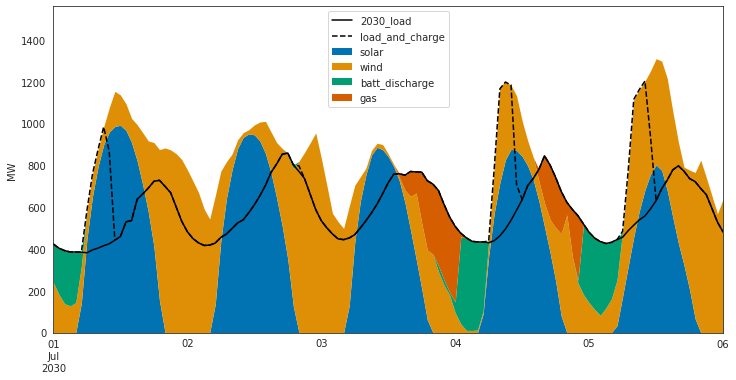

In [29]:
plot_hourly(start_date = '2030-07-01', num_days = 5)

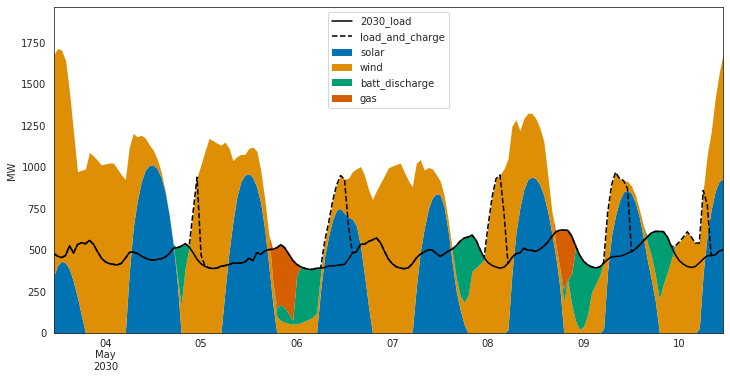

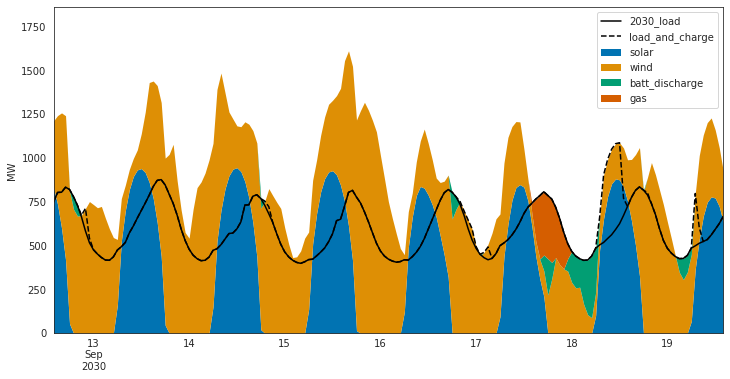

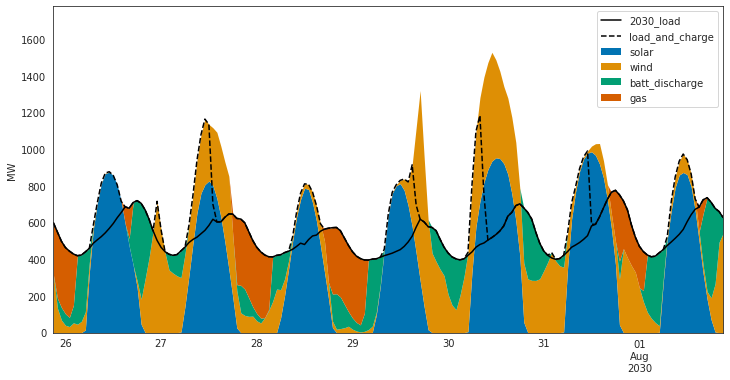

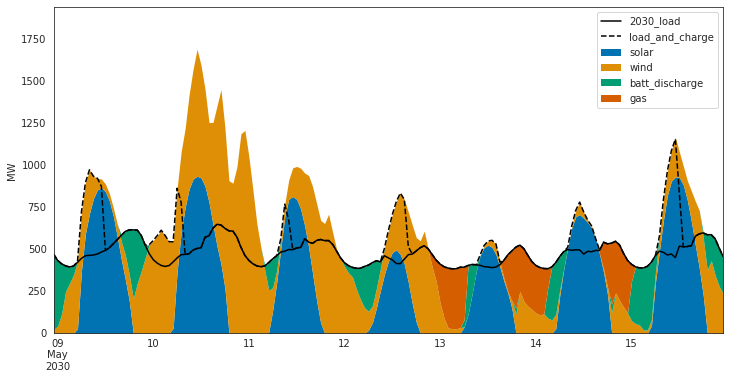

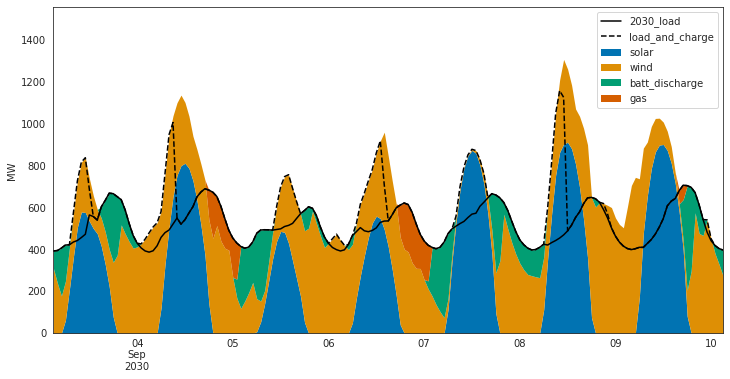

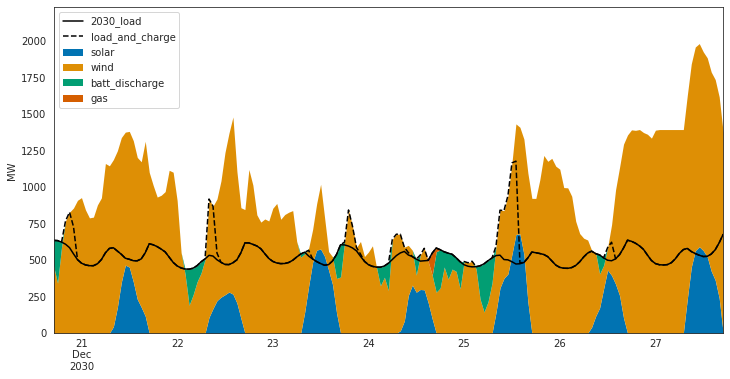

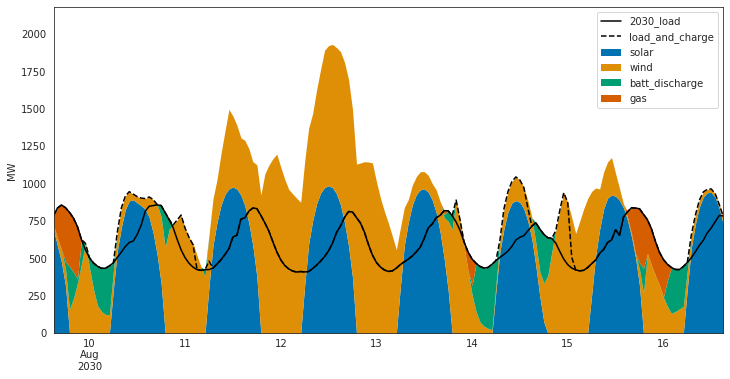

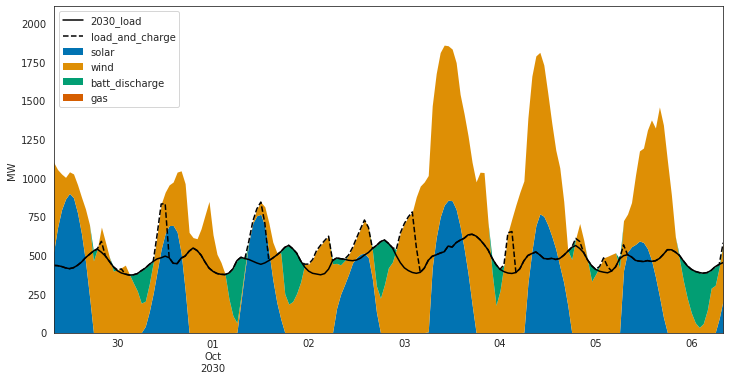

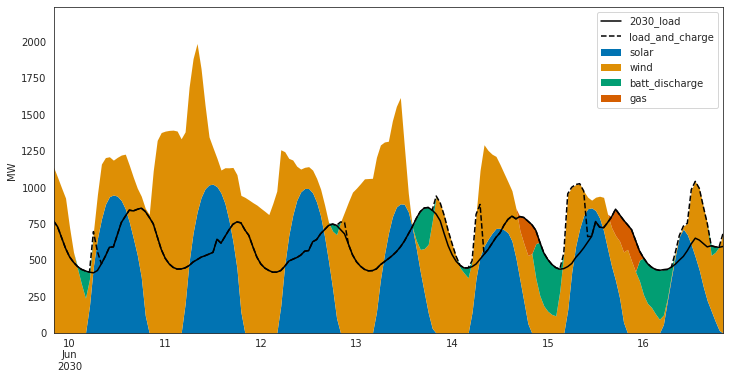

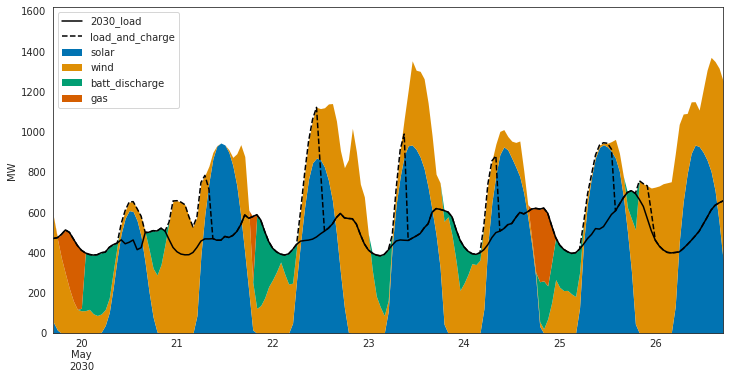

In [30]:
# generate random plots
for i in range(10):
    plot_hourly()